In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimisation with Stochastic Gradient Descent

The reaction rates of the circuits can be directly optimised with the automatic differentiation provided by jax

In [30]:
from datetime import datetime 
import jax 
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optax
from scipy.special import factorial
import diffrax as dfx
from functools import partial
from bioreaction.misc.misc import flatten_listlike
from synbio_morpher.utils.misc.helper import processor

jax.config.update('jax_platform_name', 'gpu')

np.random.seed(0)


In [31]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


# ODE Terms
def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                             #  signal, signal_onehot: jnp.ndarray,
                             forward_rates=None, reverse_rates=None):
    return one_step_de_sim_expanded(
        spec_conc=y, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)  # + signal(t) * signal_onehot


def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5,
                                 stepsize_controller=dfx.ConstantStepSize()):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates.squeeze(), reverse_rates=reverse_rates.squeeze()
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)


def f(reverse_rates, y0, t0, t1, dt0,
      inputs, outputs, forward_rates):
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    # ys = s.ys[:np.argmax(s.ts >= np.inf), :]
    # ts = s.ts[:np.argmax(s.ts >= np.inf)]
    
    return ys

def cost_f(ys, output_idxs):
    cost = jnp.sum(jnp.abs(jnp.max(ys, axis=0)[
        output_idxs] - ys[-1, output_idxs]))
    return -cost

In [32]:
n_species = 3
n_circuits = 5
n_reactions = np.sum(np.arange(n_species+1))
tot_species = n_species + n_reactions
signal_idxs = np.array([0])
output_idxs = np.array([1, 2])
y0 = np.array([200.0] * n_species + [0.0] * n_reactions) # [None, :] * np.ones((n_circuits, 1))
k1 = 0.00150958097
t0, t1, dt0 = 0, 20, 0.001
inputs, outputs = np.zeros((n_reactions, tot_species)), np.zeros(
    (n_reactions, tot_species))
inds = flatten_listlike([[(i, j) for j in range(i, n_species)]
                        for i in range(n_species)])
for i in range(n_reactions):
    inputs[i, inds[i][0]] += 1
    inputs[i, inds[i][1]] += 1
    outputs[i, i+n_species] += 1
    
forward_rates = np.ones(n_reactions) * k1
reverse_rates = np.random.rand(n_circuits, n_reactions) * 2 * k1

f_t = partial(f, y0=y0, t0=t0, t1=t1, dt0=dt0, inputs=inputs, outputs=outputs, forward_rates=forward_rates)
c_t = partial(cost_f, output_idxs=output_idxs)
f_full = partial(processor, funcs = [f_t, c_t])


In [33]:
# Test it
cost = jax.vmap(f_full)(reverse_rates)


In [34]:
cost

Array([-379.9097 , -379.2887 , -381.55658, -378.7838 , -379.63678],      dtype=float32)

In [35]:
l2_reg_alpha = 0.1
learning_rate = 0.0001
warmup_epochs = 3
epochs = 30
n_batches = 1
warmup_fn = optax.linear_schedule(
    init_value=0., end_value=learning_rate,
    transition_steps=warmup_epochs * n_batches)
cosine_epochs = max(epochs - warmup_epochs, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=0.01, decay_steps=1000) #, alpha=l2_reg_alpha)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[warmup_epochs * n_batches])
optimiser = optax.sgd(learning_rate=schedule_fn)
optimiser_state = optimiser.init(reverse_rates[0])

In [36]:
def f_scan(inp, cr, f):
    c, r = cr
    reverse_rates, optimiser_state = inp
    c, grads = jax.vmap(jax.value_and_grad(f, argnums=0))(reverse_rates)
    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    new_reverse_rates = optax.apply_updates(reverse_rates, updates)
    # Slow down gradient if negatives appear
    new_reverse_rates = jnp.where(new_reverse_rates <= 0, optax.apply_updates(reverse_rates, 0.01 * updates), new_reverse_rates)
    reverse_rates = jnp.where(new_reverse_rates <= 0, reverse_rates / 10, new_reverse_rates)
    return [reverse_rates, optimiser_state], [c, reverse_rates]

cs = np.zeros([epochs, n_circuits])
rs = np.zeros([epochs, *reverse_rates.shape])

In [37]:
# 3 mins

ro, crs = jax.lax.scan(partial(f_scan, f=f_full), init=[reverse_rates, optimiser_state], xs=[cs, rs])

all_reverse_rates = np.concatenate([reverse_rates[None, :, :], np.zeros_like(rs)])
fin_reverse_rates, optimiser_state = ro
cs, all_reverse_rates1 = crs
all_reverse_rates[1:] = all_reverse_rates1

In [38]:
cs

Array([[-379.9097 , -379.2887 , -381.55658, -378.7838 , -379.63678],
       [-379.9097 , -379.2887 , -381.55658, -378.7838 , -379.63678],
       [-380.94464, -380.31134, -382.49158, -379.77124, -380.7387 ],
       [-382.7312 , -382.07214, -383.70264, -381.48053, -382.60364],
       [-393.5287 , -393.45093, -393.62238, -393.38602, -393.5625 ],
       [-393.80243, -393.7945 , -393.80997, -393.78415, -393.82385],
       [-393.83356, -393.83264, -393.83246, -393.82788, -393.85318],
       [-393.84015, -393.83997, -393.83826, -393.83588, -393.85913],
       [-393.84424, -393.8441 , -393.8423 , -393.8402 , -393.8626 ],
       [-393.8479 , -393.8478 , -393.846  , -393.84406, -393.8658 ],
       [-393.8515 , -393.85138, -393.84967, -393.84772, -393.86893],
       [-393.85498, -393.8549 , -393.85318, -393.8513 , -393.87195],
       [-393.85834, -393.85825, -393.85663, -393.8548 , -393.87494],
       [-393.86166, -393.86157, -393.85995, -393.85815, -393.8778 ],
       [-393.86484, -393.86472, -3

In [39]:
all_reverse_rates[-1]

array([[1.11971354e+00, 1.90146443e-30, 1.55962277e-30, 9.96157547e-31,
        6.23864286e-31, 1.30603582e-30],
       [1.11957169e+00, 2.44073215e-30, 2.66006341e-30, 5.06399910e-31,
        1.75988149e-30, 9.53522837e-31],
       [1.11730027e+00, 2.53307184e-30, 1.22501381e-32, 3.47001488e-33,
        6.10426456e-34, 1.86564533e-30],
       [1.11474299e+00, 2.37725921e-30, 2.70768503e-30, 1.78800082e-30,
        7.51904632e-31, 1.73117912e-30],
       [1.14398146e+00, 1.67657694e-30, 1.62427835e-31, 2.22106799e-30,
        9.21688475e-31, 5.90744780e-31]])

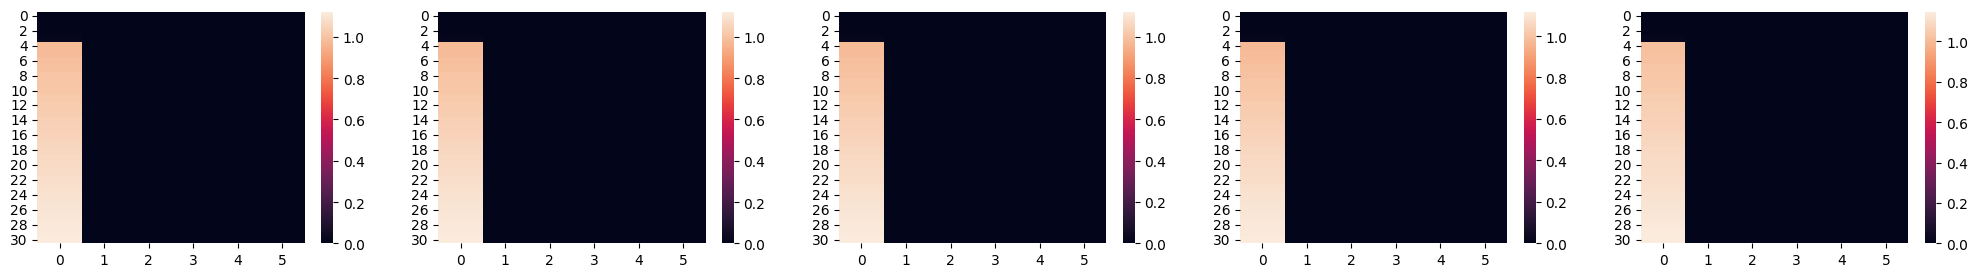

In [44]:
fig = plt.figure(figsize=(5*n_circuits, 3))
for c in range(n_circuits):
    ax = plt.subplot(1, n_circuits, c+1)
    sns.heatmap(all_reverse_rates[:, c, :])

<Axes: >

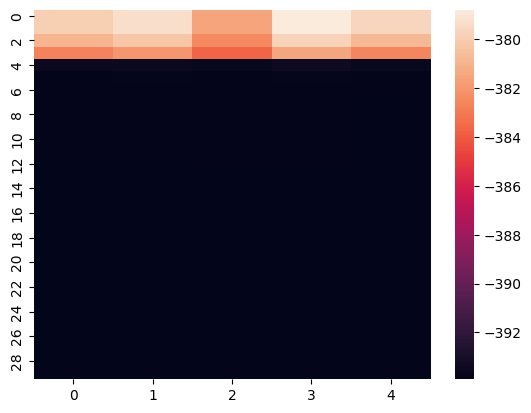

In [45]:
sns.heatmap(cs)

### Unpacked scan (for loop)

In [42]:
# cs = np.zeros([epochs, n_circuits])
# rs = np.zeros([epochs + 1, *reverse_rates.shape])
# rs[0] = reverse_rates
# inp = [reverse_rates, optimiser_state]
# for i, cr in enumerate(zip(cs, rs)):
#     if i == 1:
#         print(i)
#     inp, crs = f_scan(inp, cr)
#     fin_reverse_rates, optimiser_state = inp
#     cs[i] = np.array(crs[0])
#     rs[i+1] = crs[1]
#     if np.sum(np.isnan(rs[:, 3, :])) > 0:
#         print(rs)

In [43]:
# fig = plt.figure(figsize=(5*n_circuits, 3))
# for c in range(n_circuits):
#     ax = plt.subplot(1, n_circuits, c+1)
#     sns.heatmap(np.log10(rs[1:, c, :]))